# Project: Quantitative Analysis with S&P500 Stock Selection for Portfolio Construction

## Introduction
1. What is my objective?
    - Focus on safety portfolio.
    - Find stocks in S&P500 which has high return and acceptable risk.
    - Manage portfolio risk with 6 strategy for decided.

2. What business get?
    - Help make investment decisions based on principles, not emotions or rumors.
    - A portfolio that provides good returns at a controlled level of risk.
    - Reduce the chance of a heavy portfolio loss by diversifying your strategies.

3. Understand the dataset
    - Source
        - Stock price data collected using yfinance from Yahoo Finance.
        - Dataset includes daily adjusted close prices of S&P 500 component stocks.
    - Time Period
        - Data covers January 1, 2015 – December 31, 2024 (10 years).
        - There contain shocks, high volatilities, current in good and bad economic times.
        - Suitable for evaluating stocks in all aspects
    - Assets
        - Focus on companies listed in the S&P 500 Index (USA large-cap equity market benchmark).
        - Includes only stocks with full historical data over the selected period.

## Plans
1. Dowload data in 10 years period (around 1 economic cycle, 2015-2024).

2. Calculate Sharpe-Ratio, Beta in CAPM, Z-score for strategy

3. Create 6 strategy using 10 stocks for decided.

4. Compare both portfolio strategy using 
    - Return (CAGM), Volatility, Maximum Drawdown
    - Sharpe Ratio, Sortino Ratio, Calmar Ratio
    - VaR + Monte-Carlo

5. Conclusion

## 0. Setup basics library & data

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from scipy.stats import zscore

In [2]:
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
df = pd.read_csv(url)
tickers = df["Symbol"].str.replace(".", "-", regex=False).tolist()

## 1. Dowload Data

### 1.1 Dowload S&P500 stocks data
- Turn close price daily data to monthly.
- Normalize it using percentage change.
- Drop NULL.
- Drop out stocks which not has full historical data over the selected period.

In [3]:
start = "2014-12-01"
end = "2024-12-31"
expected_months = 12*10 + 1

ME_price = {}

for ticker in tickers:
    try:
        load = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
        data = load["Close"].resample("ME").last().ffill()

        if len(data) == expected_months:
            ME_price[ticker] = data
            
    except Exception as e:
        print(f"{ticker} error: {e}")

### 1.2 Format and Check data

In [4]:
cl_price = pd.concat(ME_price.values(), axis=1)
cl_price.columns = ME_price.keys()

In [5]:
cl_price.isnull().sum().max()

np.int64(0)

In [6]:
cl_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2014-12-31 to 2024-12-31
Freq: ME
Columns: 469 entries, MMM to ZTS
dtypes: float64(469)
memory usage: 444.3 KB


In [7]:
cl_price.head()

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,97.121162,23.883533,36.843021,42.468998,75.018784,72.699997,2.67,9.413013,23.808064,37.531136,...,24.521494,101.165657,81.610001,128.167313,25.794262,33.326595,42.918785,77.410004,101.457214,39.763733
2015-01-31,95.927261,25.153709,36.824135,39.459740,70.583687,70.129997,2.57,8.421144,22.245283,34.709877,...,23.932196,97.756607,79.459999,127.469490,26.950422,29.851246,42.824780,83.459999,100.276428,39.560749
2015-02-28,100.300415,26.769918,38.971394,39.557812,75.623543,79.099998,3.11,8.937990,24.414133,38.790142,...,26.758656,107.735466,85.500000,123.976433,25.334681,31.376120,48.056423,91.050003,107.692085,42.671539
2015-03-31,98.099930,27.886929,38.115768,38.276276,78.697906,73.940002,2.68,8.855289,25.104397,38.277668,...,27.944269,109.480316,84.410004,109.516861,25.231548,30.778484,46.640392,90.720001,105.319023,42.856712
2015-04-30,93.009079,27.217695,38.385212,42.628471,78.656670,76.059998,2.26,9.130947,24.723963,38.111847,...,28.275681,110.502853,91.209999,96.632027,24.579191,32.536243,51.198086,92.080002,98.436363,41.199207


## 2. Choose 10 stocks for portfolio

### 2.1 Sharpe-Ratio
- Turn risk-free rate using 10-Year Treasury Yield (2015-2024) ≈ 2.3% annually to monthly
- For strategy 2
    - Choose stocks with Sharpe Ratio > 1.0

In [8]:
rf_annual = 0.023
rf_monthly = (1 + rf_annual) ** (1/12) - 1

In [9]:
def CAGR(DF):
    df = DF.copy().pct_change().dropna()
    df = (1 + df).cumprod()
    n = len(df) / 12
    return (df.iloc[-1])**(1/n) - 1

def volatility(DF):
    df = DF.copy().pct_change().dropna()
    return df.std() * np.sqrt(12)

def sharpe(series):
    return (CAGR(series) - rf_monthly) / volatility(series)

In [10]:
results = pd.DataFrame(index=cl_price.columns)
results["CAGR"] = cl_price.apply(CAGR)
results["Volatility"] = cl_price.apply(volatility)
results["Sharpe"] = cl_price.apply(sharpe)

selected_stocks = results[results["Sharpe"] > 1.0]

print("Sharpe Ratio > 1.0 with CAGR")
len(selected_stocks)

Sharpe Ratio > 1.0 with CAGR


19

### 2.2 beta
- For strategy 1
    - Choose stocks with Sharpe Ratio > 1.0
    - And beta is acceptable

In [11]:
market_data = yf.download("^GSPC", start=start, end=end, progress=False, auto_adjust=True)
market_close = market_data["Close"].resample("ME").last().ffill()
market_returns = market_close.pct_change().dropna()

In [12]:
market_returns.isnull().sum().max()

np.int64(0)

In [13]:
def calc_beta(stock_returns, market_returns):
    cov_matrix = np.cov(stock_returns, market_returns)
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    return beta

In [14]:
beta_list = []

for ticker in selected_stocks.index:
    stock_returns = cl_price[ticker].pct_change().dropna()

    aligned = pd.concat([stock_returns, market_returns], axis=1).dropna()
    beta = calc_beta(aligned.iloc[:, 0], aligned.iloc[:, 1])
    beta_list.append(beta)

In [15]:
selected_stocks = results[results["Sharpe"] > 1.0].copy()
selected_stocks["Beta"] = beta_list

print("Stocks with Sharpe Ratio > 1.0 and corresponding Beta:")
print(selected_stocks.info())

Stocks with Sharpe Ratio > 1.0 and corresponding Beta:
<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, ANET to TMUS
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CAGR        19 non-null     float64
 1   Volatility  19 non-null     float64
 2   Sharpe      19 non-null     float64
 3   Beta        19 non-null     float64
dtypes: float64(4)
memory usage: 760.0+ bytes
None


### 2.3 z-score
- For strategy 3
    - Choose stocks with zscore is top

In [16]:
zdf = results.copy()

zdf["z_sharpe"] = zscore(zdf["Sharpe"].fillna(0))
zdf["z_cagr"] = zscore(zdf["CAGR"].fillna(0))
zdf["z_vol"] = zscore(zdf["Volatility"].fillna(0))

zdf["CompositeScore"] = zdf["z_sharpe"] + zdf["z_cagr"] - zdf["z_vol"]
zdf.sort_values("CompositeScore", ascending=False).head(10)

,CAGR,Volatility,Sharpe,z_sharpe,z_cagr,z_vol,CompositeScore
NVDA,0.760323,0.466290,1.626511,3.925690,7.030057,1.895287,9.060460
AVGO,0.408486,0.321099,1.266245,2.741093,3.179446,0.355059,5.565480
FICO,0.394960,0.309748,1.268977,2.750076,3.031405,0.234647,5.546835
PGR,0.275573,0.206388,1.326030,2.937674,1.724802,-0.861824,5.524300
CDNS,0.318784,0.257972,1.228379,2.616587,2.197722,-0.314602,5.128910
MSFT,0.266891,0.218811,1.211063,2.559649,1.629780,-0.730033,4.919462
RSG,0.196251,0.159697,1.217016,2.579225,0.856680,-1.357124,4.793029
LLY,0.297961,0.254626,1.162742,2.400763,1.969822,-0.350100,4.720685
MSCI,0.302890,0.263355,1.142920,2.335587,2.023768,-0.257503,4.616859
TMUS,0.236397,0.207748,1.128769,2.289056,1.296043,-0.847389,4.432488


### 2.4 Prepare data for strategy
- Strategy 1
    - Choose stocks which Sharpe-Ratio > 1.0
    - 10% or 1 stocks: (beta > 1.2) with most return --> argressive stocks
    - 20% or 2 stocks: (1.2 > beta > 1.0) with most return --> growth stocks
    - 30% or 3 stocks: (1.0 > beta > 0.8) with most return --> balance stocks
    - 40% or 4 stocks: (0.8 > beta) with most return --> defensive stocks

-  Strategy 2
    - Top 10 stocks with most Sharpe-Ratio

- Strategy 3
    - Top 10 stocks with most z-score

- Strategy 4
    - Rebalancing Portfolio monthly using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

- Strategy 5
    - Rebalancing Portfolio quarterly using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

- Strategy 6
    - Rebalancing Portfolio annually using top 10 stocks with most return in S&P500
    - We will show this code on section 3.

In [18]:
## check
print((selected_stocks["Beta"] > 1.2).sum())
print(((1.2 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 1.0)).sum())
print(((1.0 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 0.8)).sum())
print((0.8 > selected_stocks["Beta"]).sum())

4
6
4
5


In [19]:
## Strategy 1
group1 = selected_stocks[selected_stocks["Beta"] > 1.2].nlargest(1, "CAGR")
group2 = selected_stocks[(1.2 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 1.0)].nlargest(2, "CAGR")
group3 = selected_stocks[(1.0 > selected_stocks["Beta"]) & (selected_stocks["Beta"] > 0.8)].nlargest(3, "CAGR")
group4 = selected_stocks[0.8 > selected_stocks["Beta"]].nlargest(4, "CAGR")

strategy1 = pd.concat([group1, group2, group3, group4])
len(strategy1)

10

In [20]:
## Strategy 2
strategy2 = selected_stocks.nlargest(10, "Sharpe")
len(strategy2)

10

In [21]:
## Strategy 3
strategy3 = zdf.nlargest(10, "CompositeScore")

### 2.5 Optimize code (Maximize Sharpe-Ratio)
- Find best portfolio by Maxmimize Sharpe-Ratio

In [22]:
returns_series = cl_price.pct_change().dropna()

strategy1_series = returns_series[strategy1.index.tolist()]
strategy2_series = returns_series[strategy2.index.tolist()]
strategy3_series = returns_series[strategy3.index.tolist()]

In [54]:
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

## Gen Portfolios
def generate_portfolios(strategy):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    mean_returns = strategy.mean(axis=0)
    cov_matrix = strategy.cov()
    num_assets = strategy.shape[1]

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(num_assets)
        w /= np.sum(w)

        portfolio_weights.append(w)
        portfolio_means.append(np.dot(w, mean_returns))
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, strategy):
    portfolio_return = np.sum(strategy.mean(axis=0) * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(strategy.cov(), weights)))
    sharpe = (portfolio_return - rf_monthly) / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe])

def min_function_sharpe(weights, strategy):
    return -statistics(weights, strategy)[2]

def optimize_portfolio(weights, strategy):
    num_assets = strategy.shape[1]
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    return optimization.minimize(fun=min_function_sharpe, x0=weights, args=(strategy,)
                                 , method='SLSQP', bounds=bounds, constraints=constraints)

def print_optimal_portfolio(optimum, strategy):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), strategy))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()

### 2.6 Backtesting code (Rebalance Portfolio)
- Using stocks weight equally, means each stock are 10% of portfolio

In [25]:
def pflio_monthly(DF,m,x):
    """
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [26]:
def pflio_quarterly(DF, m, x):
    """
    DF = dataframe with monthly return info for all stocks
    m = number of stocks in the portfolio
    x = number of underperforming stocks to be removed from the portfolio every quarter
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]

    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean())
        else:
            monthly_ret.append(0)

        if i % 3 == 0:
            if len(portfolio) > 0:
                bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
                portfolio = [t for t in portfolio if t not in bad_stocks]

            fill = m - len(portfolio)
            new_picks = df.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
            portfolio = portfolio + new_picks

            print(f"Month {i}: Portfolio = {portfolio}")

    monthly_ret = monthly_ret[:len(df)]
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

In [27]:
def pflio_annually(DF, m, x):
    """
    DF = dataframe with monthly return info for all stocks
    m = number of stocks in the portfolio
    x = number of underperforming stocks to be removed from the portfolio every annual
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]

    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i, :].mean())
        else:
            monthly_ret.append(0)

        if i % 12 == 0:
            if len(portfolio) > 0:
                bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
                portfolio = [t for t in portfolio if t not in bad_stocks]

            fill = m - len(portfolio)
            new_picks = df.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
            portfolio = portfolio + new_picks

            print(f"Month {i}: Portfolio = {portfolio}")

    monthly_ret = monthly_ret[:len(df)]
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret), columns=["mon_ret"])
    return monthly_ret_df

## 3. Strategy with Optimize & Backtesting

### 3.1 Optimize Strategy 1

Optimal portfolio:  [0.136 0.125 0.    0.    0.    0.    0.215 0.291 0.191 0.042]
Expected return, volatility and Sharpe ratio:  [0.02811914 0.04300998 0.60968134]


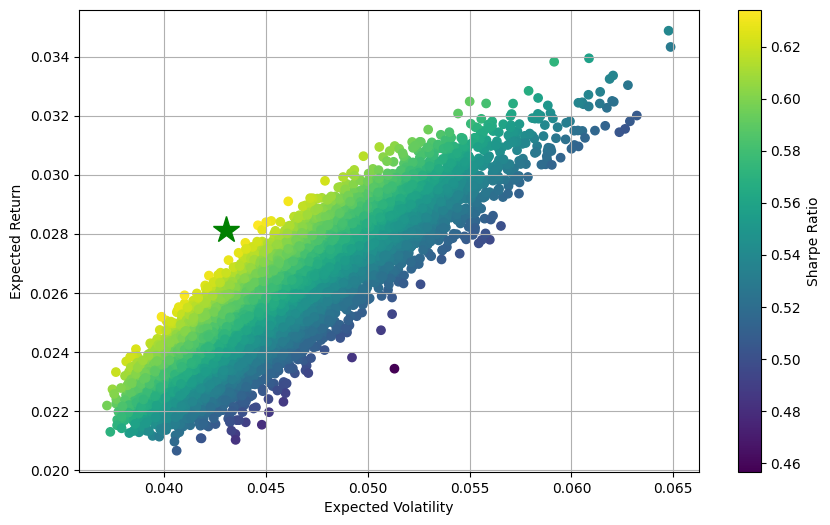

In [55]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy1_series)
    optimum = optimize_portfolio(pweights[0], strategy1_series)
    print_optimal_portfolio(optimum, strategy1_series)
    show_optimal_portfolio(optimum, strategy1_series, means, risks)

### 3.2 Optimize Strategy 2

Optimal portfolio:  [0.129 0.267 0.008 0.116 0.    0.072 0.    0.208 0.025 0.174]
Expected return, volatility and Sharpe ratio:  [0.02766057 0.04213581 0.61144692]


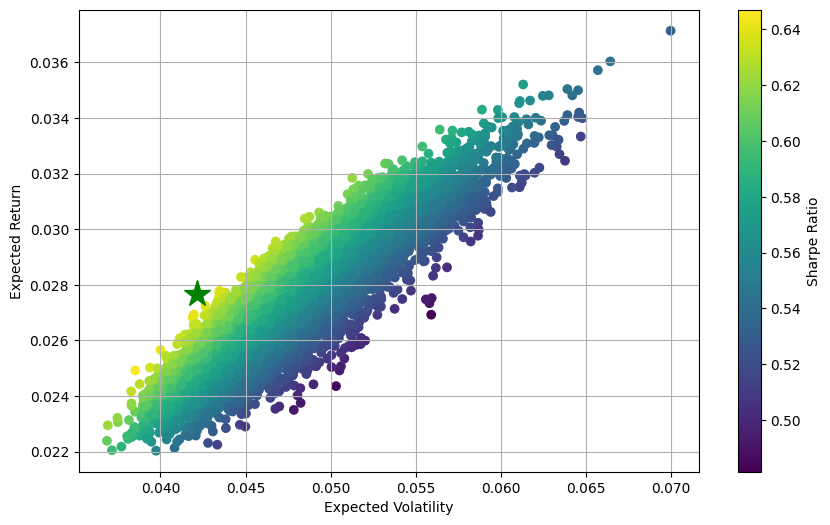

In [29]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy2_series)
    optimum = optimize_portfolio(pweights[0], strategy2_series)
    print_optimal_portfolio(optimum, strategy2_series)
    show_optimal_portfolio(optimum, strategy2_series, means, risks)

### 3.3 Optimize Strategy 3

Optimal portfolio:  [0.129 0.116 0.009 0.268 0.    0.    0.072 0.208 0.025 0.174]
Expected return, volatility and Sharpe ratio:  [0.02771474 0.04221817 0.61153733]


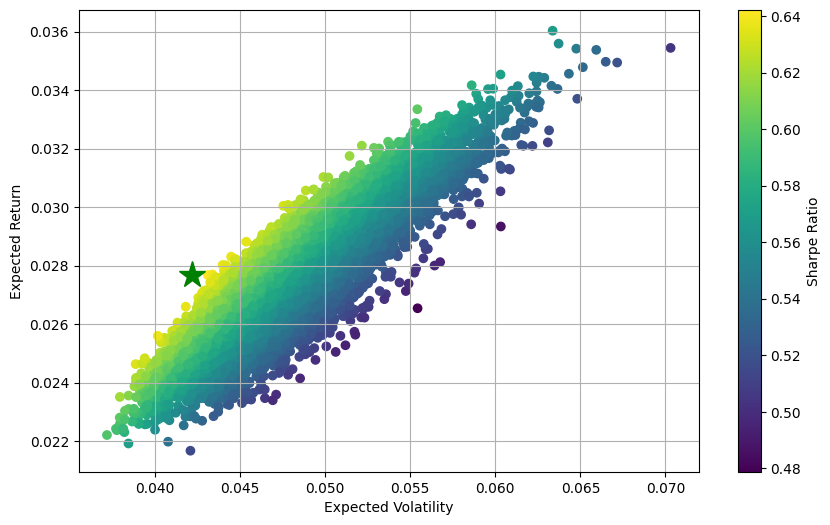

In [30]:
if __name__ == '__main__':
    pweights, means, risks = generate_portfolios(strategy3_series)
    optimum = optimize_portfolio(pweights[0], strategy3_series)
    print_optimal_portfolio(optimum, strategy3_series)
    show_optimal_portfolio(optimum, strategy3_series, means, risks)

### 3.4 Backtesting Strategy 4
- Backtesting using rebalance portfolio monthly

In [41]:
strategy4_ret_df = pflio_monthly(returns_series, m=10, x=10)
strategy4_cum = (1 + strategy4_ret_df["mon_ret"]).cumprod()

cagr_monthly = strategy4_cum.iloc[-1].item() ** (12 / len(strategy4_cum)) - 1
vol_monthly = strategy4_ret_df["mon_ret"].std() * np.sqrt(12)
sharpe_monthly = (cagr_monthly - rf_annual) / vol_monthly

print("\n")
print(f"CAGR: {cagr_monthly:.4%}")
print(f"Volatility: {vol_monthly:.4%}")
print(f"Sharpe Ratio: {sharpe_monthly:.2f}")

['NEM', 'NFLX', 'LULU', 'EA', 'FANG', 'BIIB', 'AMZN', 'O', 'SWKS', 'HOLX']
['FSLR', 'TKO', 'MLM', 'FCX', 'ON', 'EPAM', 'MOH', 'AVGO', 'CRM', 'BKNG']
['NXPI', 'CNC', 'COO', 'CBRE', 'SWKS', 'RMD', 'STLD', 'COR', 'BLDR', 'ROL']
['BLDR', 'CZR', 'NFLX', 'AXON', 'FCX', 'NEM', 'VTRS', 'TSLA', 'MSFT', 'LYB']
['HUM', 'AVGO', 'MOH', 'CNC', 'ZBRA', 'SWKS', 'NXPI', 'SMCI', 'TER', 'CZR']
['ANET', 'TKO', 'CI', 'ROL', 'WMB', 'CAG', 'DXCM', 'HCA', 'UHS', 'PODD']
['AMZN', 'CMG', 'NFLX', 'GOOGL', 'GOOG', 'TKO', 'BLDR', 'FTNT', 'AMGN', 'VRSN']
['PAYC', 'BBY', 'NVDA', 'CZR', 'INCY', 'DXCM', 'CDW', 'SYY', 'FSLR', 'MSI']
['TAP', 'TPL', 'JBL', 'IRM', 'NI', 'NKE', 'NVDA', 'WEC', 'EIX', 'TYL']
['TRMB', 'KLAC', 'FSLR', 'WYNN', 'LVS', 'LDOS', 'MGM', 'ADSK', 'URI', 'AMD']
['PODD', 'NSC', 'NXPI', 'CRL', 'PANW', 'VTRS', 'DLTR', 'ADSK', 'PAYC', 'ANET']
['ENPH', 'AMD', 'FSLR', 'CNC', 'CZR', 'DRI', 'AVGO', 'KR', 'ULTA', 'WYNN']
['SMCI', 'EQT', 'LULU', 'CTRA', 'TPR', 'FANG', 'KMI', 'HAS', 'NEM', 'ATO']
['FCX', 'NEM', '

### 3.5 Backtesting Strategy 5
- Backtesting using rebalance portfolio quarterly

In [40]:
strategy5_ret_df = pflio_quarterly(returns_series, m=10, x=10)
strategy5_cum = (1 + strategy5_ret_df["mon_ret"]).cumprod()

cagr_quarterly = strategy5_cum.iloc[-1].item() ** (12 / len(strategy5_cum)) - 1
vol_quarterly = strategy5_ret_df["mon_ret"].std() * np.sqrt(12)
sharpe_quarterly = (cagr_quarterly - rf_annual) / vol_quarterly

print("\n")
print(f"CAGR: {cagr_quarterly:.4%}")
print(f"Volatility: {vol_quarterly:.4%}")
print(f"Sharpe Ratio: {sharpe_quarterly:.2f}")

Month 0: Portfolio = ['NEM', 'NFLX', 'LULU', 'EA', 'FANG', 'BIIB', 'AMZN', 'O', 'SWKS', 'HOLX']
Month 3: Portfolio = ['BLDR', 'CZR', 'NFLX', 'AXON', 'FCX', 'NEM', 'VTRS', 'TSLA', 'MSFT', 'LYB']
Month 6: Portfolio = ['AMZN', 'CMG', 'NFLX', 'GOOGL', 'GOOG', 'TKO', 'BLDR', 'FTNT', 'AMGN', 'VRSN']
Month 9: Portfolio = ['TRMB', 'KLAC', 'FSLR', 'WYNN', 'LVS', 'LDOS', 'MGM', 'ADSK', 'URI', 'AMD']
Month 12: Portfolio = ['SMCI', 'EQT', 'LULU', 'CTRA', 'TPR', 'FANG', 'KMI', 'HAS', 'NEM', 'ATO']
Month 15: Portfolio = ['TRGP', 'FCX', 'NEM', 'DVN', 'AMD', 'OKE', 'WMB', 'EW', 'RF', 'COP']
Month 18: Portfolio = ['DHR', 'AMD', 'EBAY', 'STX', 'GRMN', 'STT', 'REGN', 'NVDA', 'BIIB', 'IQV']
Month 21: Portfolio = ['AKAM', 'NFLX', 'KEY', 'VLO', 'DPZ', 'NOW', 'FFIV', 'TPL', 'EXPE', 'GS']
Month 24: Portfolio = ['ENPH', 'NRG', 'DXCM', 'CSX', 'MKTX', 'FCX', 'WDAY', 'SWKS', 'NOW', 'INCY']
Month 27: Portfolio = ['ALGN', 'EW', 'CSGP', 'MTCH', 'TER', 'WST', 'TSLA', 'LRCX', 'MGM', 'TDG']
Month 30: Portfolio = ['NRG'

### 3.6 Backtesting Strategy 6
- Backtesting using rebalance portfolio annually

In [42]:
strategy6_ret_df = pflio_annually(returns_series, m=10, x=10)
strategy6_cum = (1 + strategy6_ret_df["mon_ret"]).cumprod()

cagr_annually = strategy6_cum.iloc[-1].item() ** (12 / len(strategy6_cum)) - 1
vol_annually = strategy6_ret_df["mon_ret"].std() * np.sqrt(12)
sharpe_annually = (cagr_annually - rf_annual) / vol_annually

print("\n")
print(f"CAGR: {cagr_annually:.4%}")
print(f"Volatility: {vol_annually:.4%}")
print(f"Sharpe Ratio: {sharpe_annually:.2f}")

Month 0: Portfolio = ['NEM', 'NFLX', 'LULU', 'EA', 'FANG', 'BIIB', 'AMZN', 'O', 'SWKS', 'HOLX']
Month 12: Portfolio = ['SMCI', 'EQT', 'LULU', 'CTRA', 'TPR', 'FANG', 'KMI', 'HAS', 'NEM', 'ATO']
Month 24: Portfolio = ['ENPH', 'NRG', 'DXCM', 'CSX', 'MKTX', 'FCX', 'WDAY', 'SWKS', 'NOW', 'INCY']
Month 36: Portfolio = ['NFLX', 'AMD', 'STX', 'NVDA', 'AMZN', 'KDP', 'EA', 'TPL', 'BA', 'IDXX']
Month 48: Portfolio = ['ENPH', 'GE', 'HES', 'AMD', 'CZR', 'APTV', 'TPL', 'SYF', 'META', 'NFLX']
Month 60: Portfolio = ['TSLA', 'PCG', 'ENPH', 'PAYC', 'NOW', 'LEN', 'SMCI', 'PHM', 'PGR', 'TDG']
Month 72: Portfolio = ['WBD', 'AXON', 'PARA', 'EQT', 'WSM', 'WBA', 'KMX', 'LLY', 'GM', 'F']
Month 84: Portfolio = ['HAL', 'SLB', 'OXY', 'EOG', 'HES', 'XOM', 'APA', 'COP', 'WBD', 'PSX']
Month 96: Portfolio = ['WBD', 'TSLA', 'WDC', 'PARA', 'CCL', 'NVDA', 'RCL', 'EXPE', 'MKTX', 'MTCH']
Month 108: Portfolio = ['SMCI', 'JNPR', 'NVDA', 'NFLX', 'WRB', 'PANW', 'VZ', 'AMD', 'COR', 'DECK']


CAGR: 26.9558%
Volatility: 27.0615%

## 4. Compare Strategy with KPI

### 4.1 Compare CAGR, Volatility, Sharpe-Ratio
- As result, return of Strategy 1, 2, 3 using "Maximize Sharpe-Raito" is bad because
    - Keep the stocks at the same all base on Sharpe-Ratio, Beta, Z-score
    - No changing in anything even there are shocks or crisis.

- As result, return of Strategy 4, 5, 6 using "Rebalancing Portfolio" is great because
    - Keep changing stocks all the time base on highest return.
    - This help portfolio always tune.

In [62]:
print("Strategy1")
print_optimal_portfolio(optimum, strategy1_series)

print("\n Strategy2")
print_optimal_portfolio(optimum, strategy2_series)

print("\n Strategy3")
print_optimal_portfolio(optimum, strategy3_series)

print("\n Strategy4")
print(f"CAGR: {cagr_monthly:.4%}")
print(f"Volatility: {vol_monthly:.4%}")
print(f"Sharpe Ratio: {sharpe_monthly:.2f}")

print("\n Strategy5")
print(f"CAGR: {cagr_quarterly:.4%}")
print(f"Volatility: {vol_quarterly:.4%}")
print(f"Sharpe Ratio: {sharpe_quarterly:.2f}")

print("\n Strategy6")
print(f"CAGR: {cagr_annually:.4%}")
print(f"Volatility: {vol_annually:.4%}")
print(f"Sharpe Ratio: {sharpe_annually:.2f}")

Strategy1
Optimal portfolio:  [0.136 0.125 0.    0.    0.    0.    0.215 0.291 0.191 0.042]
Expected return, volatility and Sharpe ratio:  [0.02811914 0.04300998 0.60968134]

 Strategy2
Optimal portfolio:  [0.136 0.125 0.    0.    0.    0.    0.215 0.291 0.191 0.042]
Expected return, volatility and Sharpe ratio:  [0.02799574 0.04846544 0.53850718]

 Strategy3
Optimal portfolio:  [0.136 0.125 0.    0.    0.    0.    0.215 0.291 0.191 0.042]
Expected return, volatility and Sharpe ratio:  [0.02809963 0.04724718 0.5545912 ]

 Strategy4
CAGR: 24.5327%
Volatility: 22.1473%
Sharpe Ratio: 1.00

 Strategy5
CAGR: 21.0886%
Volatility: 24.1791%
Sharpe Ratio: 0.78

 Strategy6
CAGR: 26.9558%
Volatility: 27.0615%
Sharpe Ratio: 0.91


### 4.2 VaR + Monte-Carlo & More KPI Code for Strategy 4, 5, 6

In [82]:
def evaluate_strategy_row(strategy_name, cumulative, mon_ret, rf_annual=0.023, confidence_level=0.95):
    n = len(mon_ret)
    cagr = cumulative.iloc[-1].item() ** (12 / n) - 1
    vol = mon_ret.std() * np.sqrt(12)
    sharpe = (cagr - rf_annual) / vol
    max_dd = (cumulative / cumulative.cummax() - 1).min()
    
    downside_std = mon_ret[mon_ret < 0].std() * np.sqrt(12)
    sortino = (cagr - rf_annual) / downside_std if downside_std != 0 else np.nan
    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

    mu = mon_ret.mean()
    sigma = mon_ret.std()
    simulated_returns = np.random.normal(mu, sigma, 10000)
    var_95 = np.percentile(simulated_returns, (1 - confidence_level) * 100)

    return {
        "Strategy": strategy_name,
        "CAGR": f"{cagr:.2%}",
        "Volatility": f"{vol:.2%}",
        "Max Drawdown": f"{max_dd:.2%}",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Sortino Ratio": f"{sortino:.2f}",
        "Calmar Ratio": f"{calmar:.2f}",
        "95% Monte Carlo VaR": f"{var_95:.2%}"
    }

### 4.3 KPI for Strategy 4, 5, 6
- As result
    - Highest CAGR is Strategy 6
    - Lowest Volatility is Strategy 4
    - Lowest Max Drawdown is Strategy 4
    - Highest Sharpe Ratio is Strategy 4
    - Highest Sortino Ratio is Strategy 4
    - Highest Calmar Ratio is Strategy 4
    - Lowest Monte Carlo VaR is Strategy 4

- If you want to get highest return, you should do strategy 6.
- But if you want to lower risk and still has high return, you should do strategy 4.

In [83]:
strategy_results = []

strategy_results.append(evaluate_strategy_row("Strategy 4", strategy4_cum, strategy4_ret_df["mon_ret"]))
strategy_results.append(evaluate_strategy_row("Strategy 5", strategy5_cum, strategy5_ret_df["mon_ret"]))
strategy_results.append(evaluate_strategy_row("Strategy 6", strategy6_cum, strategy6_ret_df["mon_ret"]))

In [84]:
df_strategy_results = pd.DataFrame(strategy_results)
display(df_strategy_results)

,Strategy,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,95% Monte Carlo VaR
0,Strategy 4,24.53%,22.15%,-24.47%,1.00,1.39,1.00,-8.48%
1,Strategy 5,21.09%,24.18%,-28.12%,0.78,1.00,0.75,-9.77%
2,Strategy 6,26.96%,27.06%,-28.12%,0.91,1.28,0.96,-10.41%


## 5. Conclusion
1. Optimize Strategy
    - Strategy 1–3: Use Sharpe Ratio, CAPM, Z-score to filter stocks then Optimize Portfolio by Maximum Sharpe-Ratio
    - Result are lower risk but not very high returns (CAGR ~ 2–3%).

2. Backtesting Strategy
    - Strategy 4: Monthly Rebalancing, Reasonably good returns (CAGR ~ 24.53%) and lowest risk in all KPI
    - Strategy 5: Quarterly Rebalancing, Lowest returns (CAGR ~ 21.09%) and still high risk.
    - Strategy 6: Annually Rebalancing, Highest returns (CAGR ~ 26.96%) and highest risk.

3. From 6 strategy, I think the best is strategy 4 due to keep high return & less risk than other.
4. Using 10 stocks is less diversify but this suitable for Rebalancing Strategy which need to stay active.